# Assignment: Unsupervised Machine Learning \ Clustering

## Part 1: Partitional Clustering

In this assignment you will experience with partitional & mixture model clustering. The analyses are made on real datasets under the circumstances of real life challenges in unsupervised machine learning.

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from yellowbrick.cluster import KElbowVisualizer
%matplotlib inline

In [2]:
# pip install yellowbrick 

### Read blood test results as an EMR from an Excel file

In [3]:
# Open the file
xlsx = pd.ExcelFile('EMR-Blood.xlsx')

# Get the first sheet as an object
sheet1 = xlsx.parse(0)

# Set the Key column as the index
sheet1.set_index("Key", inplace=True)

# Show first 10 rows
sheet1[:10]

,Na,K,ALT,AST,WBC,RBC,Hgb,Hct
Key,,,,,,,,
1,141,4.65,31.92,35.01,10.25,4.06,17.6,36.3
2,140,4.96,36.41,16.70,6.13,3.80,13.2,35.6
3,136,3.66,41.43,13.17,5.86,4.26,16.2,43.7
4,136,4.74,23.92,30.33,10.80,4.83,16.1,49.8
5,140,4.74,43.66,20.44,6.59,4.05,12.6,39.1
6,146,3.98,48.41,33.22,4.53,4.04,17.9,47.3
7,144,5.29,44.29,19.28,10.12,3.96,17.2,47.9
8,138,4.57,50.43,16.39,4.66,4.91,13.7,41.5
9,144,3.96,31.51,34.87,4.57,4.72,15.1,47.6


### Blood Test Abbreviations
- Na == Sodium
- K == Potassium
- ALT == Alanine transaminase
- AST == Aspartate transaminase
- WBC == White blood cells
- RBC == Red blood cells
- Hgb == Hemoglobin
- Hct == Hematocrit

### Use K-Means to create clusters according to variables of uniform distribution

In [4]:
# Retrieve the K, WBC and Hgb column values from the dataset to cluster
variables1 = ["K","WBC","Hgb"]
EMR3d1 = sheet1.loc[:, variables1].values

In [5]:
# Run the K-Means algorithm, assuming the correct number of clusters is 5

# YOUR CODE HERE
y_pred_KMeans1 = KMeans(n_clusters=5).fit_predict(EMR3d1)

c:\Users\kherz\anaconda3\envs\ydata\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


### Make a 3D chart

C:\Users\kherz\AppData\Local\Temp\ipykernel_28700\109056837.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


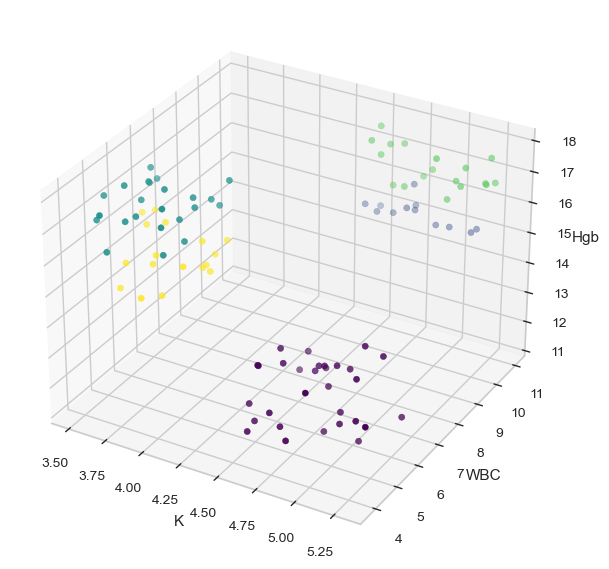

In [6]:
def make_chart (chart_data, y_pred, labels):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.scatter(chart_data[:,0], chart_data[:,1], chart_data[:,2], c=y_pred, cmap="viridis")

make_chart(EMR3d1, y_pred_KMeans1, variables1)

## Task 1 (_max score - 50 points_)
Implement  Lloyd's Algorithm for solving the K-Means problem, as shown in class. 
By examining the WCSS, choose a proper threshold to determine algorithm convergence.

Check your algorithm on 'EMR-Blood.xlsx' dataset. Compare your results to the _sklearn_ version - what can affect any differences you might've got?

In [7]:
# Add your code for task1 after this line, and keep it in this cell.

# k-means:
# - Decide how many clusters you want, i.e. choose k
# - Randomly assign a centroid to each of the k clusters
# - Calculate the distance of all observation to each of the k centroids
# - Assign observations to the closest centroid
# - Find the new location of the centroid by taking the mean of all the observations in each cluster
# - Repeat steps 3-5 until the centroids do not change position

# Implement K-Means (X being the data)
class MyKMeans:
    def __init__(self, k, max_iter=300, tol=1e-4):
        self.k = k
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None
        self.wcss_history = []
    
    def fit(self, X):
        self._initialize_centroids(X)
        
        for _ in range(self.max_iter):
            cluster_assignments = self._assign_closest_centroids(X)
            self._update_centroids(X, cluster_assignments)
            
            # Save WCSS value for this iteration.
            self.wcss_history.append(self._compute_wcss(X))

            # Stop if WCSS is decreasing but the change is very small.
            if 0 <= self._get_delta_wcss_from_history() < self.tol:
                return

        print(f"max_iter={self.max_iter} reached, WCSS failed to converge")

    def predict(self, X):
        return self._assign_closest_centroids(X)

    def get_wcss(self):
        return self.wcss_history[-1]

    def get_num_iter(self):
        return len(self.wcss_history)

    def _initialize_centroids(self, X):
        rng = np.random.default_rng()
        self.centroids = rng.choice(X, self.k, replace=False)

    def _assign_closest_centroids(self, X):
        return np.argmin(self._get_distances_from_centroids(X), axis=1)

    def _get_distances_from_centroids(self, X):
        """Return Euclidean distance between each sample in X and each centroid."""
        return np.sqrt(np.square(self.centroids - np.expand_dims(X, axis=1)).sum(axis=-1))
    
    def _update_centroids(self, X, cluster_assignments):
        """Update centroids positions based on mean of all samples assigned to each cluster."""
        self.centroids = np.array([X[cluster_assignments==i].mean(axis=0) for i in range(self.centroids.shape[0])])

    def _compute_wcss(self, X):
        """Return WCSS: within-cluster sum of squares."""
        distances = np.square(self._get_distances_from_centroids(X))
        assignments = np.argmin(distances, axis=1)
        return np.array([distances[assignments==i, i].sum() for i in range(self.centroids.shape[0])]).sum()

    def _get_delta_wcss_from_history(self):
        """Return change in WCSS since the last iteration.
        
        Positive value indicates WCSS decreased, while negative value indicates an increase.
        """
        assert len(self.wcss_history) > 0
        if len(self.wcss_history) == 1:
            return self.wcss_history[-1]
        return self.wcss_history[-2] - self.wcss_history[-1]


C:\Users\kherz\AppData\Local\Temp\ipykernel_28700\109056837.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


WCSS: 95.1677 after 8 iterations


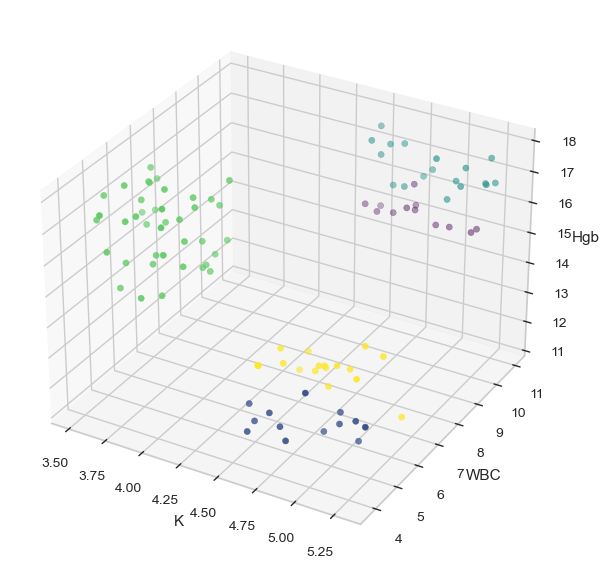

In [8]:
kmeans = MyKMeans(k=5)
kmeans.fit(EMR3d1)
y_myknn = kmeans.predict(EMR3d1)
make_chart(EMR3d1, y_myknn, variables1)
print(f"WCSS: {kmeans.get_wcss():.4f} after {kmeans.get_num_iter()} iterations")

By examining the WCSS, choose a proper threshold to determine algorithm convergence.

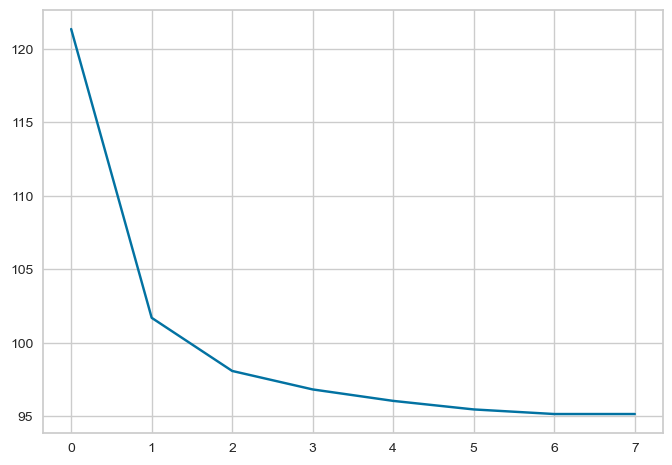

In [9]:
plt.plot(kmeans.wcss_history)

c:\Users\kherz\anaconda3\envs\ydata\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\kherz\AppData\Local\Temp\ipykernel_28700\109056837.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


WCSS: 87.0302 after 3 iterations


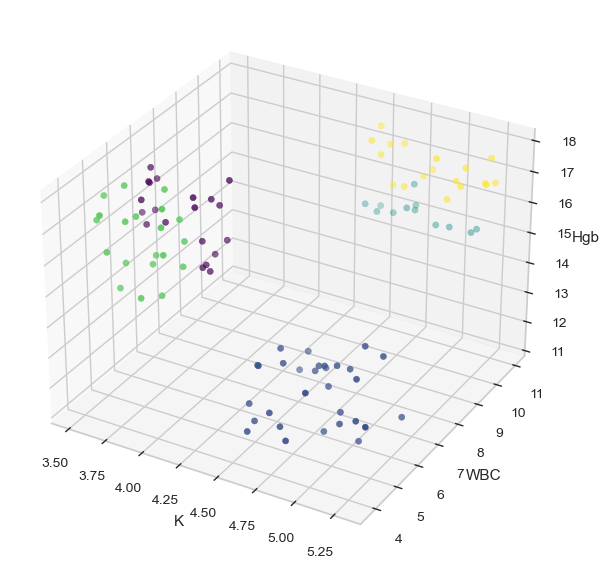

In [10]:
# scikit-learn 
sklearn_kmeans = KMeans(n_clusters=5)
y_sklearn = sklearn_kmeans.fit_predict(EMR3d1)
make_chart(EMR3d1, y_sklearn, variables1)
print(f"WCSS: {sklearn_kmeans.inertia_:.4f} after {sklearn_kmeans.n_iter_} iterations")

##### what can affect any differences you might've got?
 - My implementation produces different clusters on each run of the algorithm. This is because it is very sensitive to the randomly initialized cluster centroids.
 - The sklearn implementation solved this problem using the k-means++ algorithm for initializing the centroids (rather than randomly), contolled by the `init` parameter. Additionally, sklearn has an `n_init` option which defaults to 10. This means that sklearn actually runs the k-means fit 10 times with different initial centroids and chooses the best result.

## Task 2 (_max score - 30 points_)

Humans can clearly spot 3 clusters, however, for machines it's much harder to "learn" that. In the above implementation, K-Means was given the value of 5 as K.
Develop a **generic** mechanism for finding the most reasonable number of clusters by:
1. Iterating K over a reasonable range, which should be derived from the number of points
2. Choose a proper K based on the heuristics learned in class
3. Showing the final clusters in a 3D chart (for your implementation of K-Means algorithm)

Text(0, 0.5, 'WCSS')

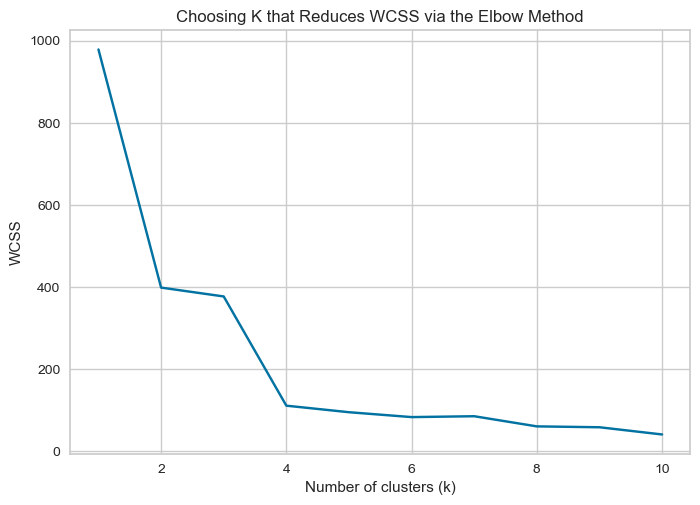

In [11]:
# Add your code for task2 after this line, and keep it in this cell.
k_sweep = list(range(1,11))
wcss = []
for k in k_sweep:
    model = MyKMeans(k)
    model.fit(EMR3d1)
    wcss.append(model.get_wcss())

plt.plot(k_sweep, wcss)
plt.title('Choosing K that Reduces WCSS via the Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')

C:\Users\kherz\AppData\Local\Temp\ipykernel_28700\109056837.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


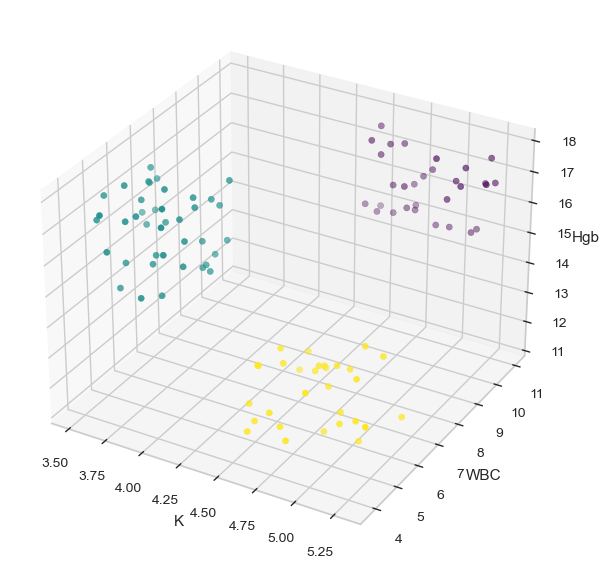

In [12]:
# k=3 is best using the elbow method.
model = MyKMeans(k=3)
model.fit(EMR3d1)
make_chart(EMR3d1, model.predict(EMR3d1), variables1)

c:\Users\kherz\anaconda3\envs\ydata\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kherz\anaconda3\envs\ydata\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kherz\anaconda3\envs\ydata\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kherz\anaconda3\envs\ydata\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMe

Text(0, 0.5, 'WCSS')

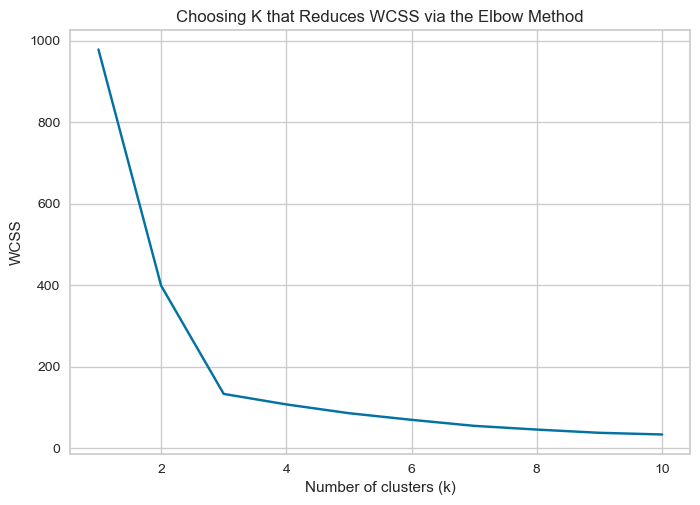

In [13]:
# Example using sklearn:
k_sweep = list(range(1,11))
wcss = []
for k in k_sweep:
    kmeans = KMeans(k)
    kmeans.fit(EMR3d1)
    wcss.append(kmeans.inertia_)

plt.plot(k_sweep, wcss)
plt.title('Choosing K that Reduces WCSS via the Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')

c:\Users\kherz\anaconda3\envs\ydata\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\kherz\AppData\Local\Temp\ipykernel_28700\109056837.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


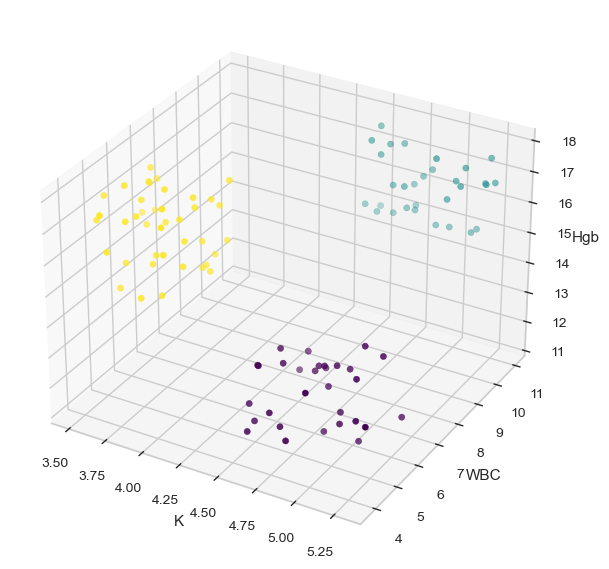

In [14]:
# k=3 is best using the elbow method.
model = KMeans(3)
model.fit(EMR3d1)
make_chart(EMR3d1, model.predict(EMR3d1), variables1)

c:\Users\kherz\anaconda3\envs\ydata\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kherz\anaconda3\envs\ydata\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kherz\anaconda3\envs\ydata\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kherz\anaconda3\envs\ydata\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMe

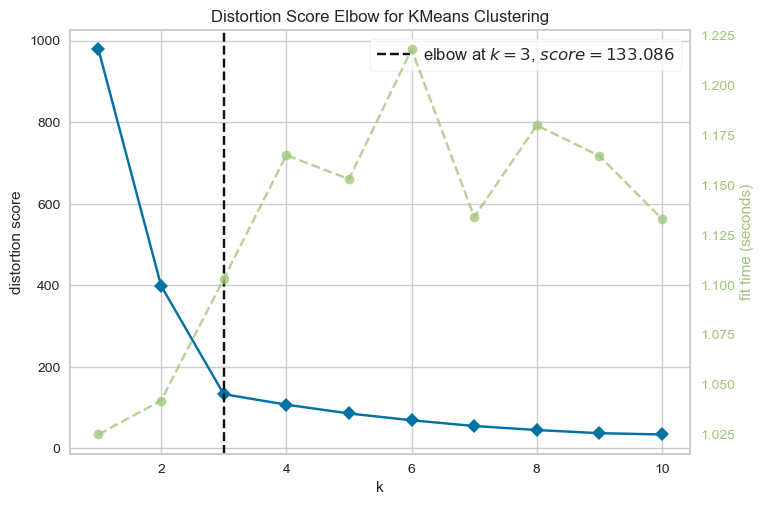

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
# Example using Yellowbrick KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(), k=(1,11))
visualizer.fit(EMR3d1)        # Fit the data to the visualizer
visualizer.show()             # Finalize and render the figure

### Silhouette analysis

Use graphic visualization of the Silhouette score to support your above answer:

In [16]:
# Add your code for the Sillhouette graphic analysis
# You can use scikit-learn Sillhouette page as a reference

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

def plot_Silhouette(X, n_clusters):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = MyKMeans(n_clusters)
    clusterer.fit(X)
    cluster_labels = clusterer.predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.centroids
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.5738344190137955


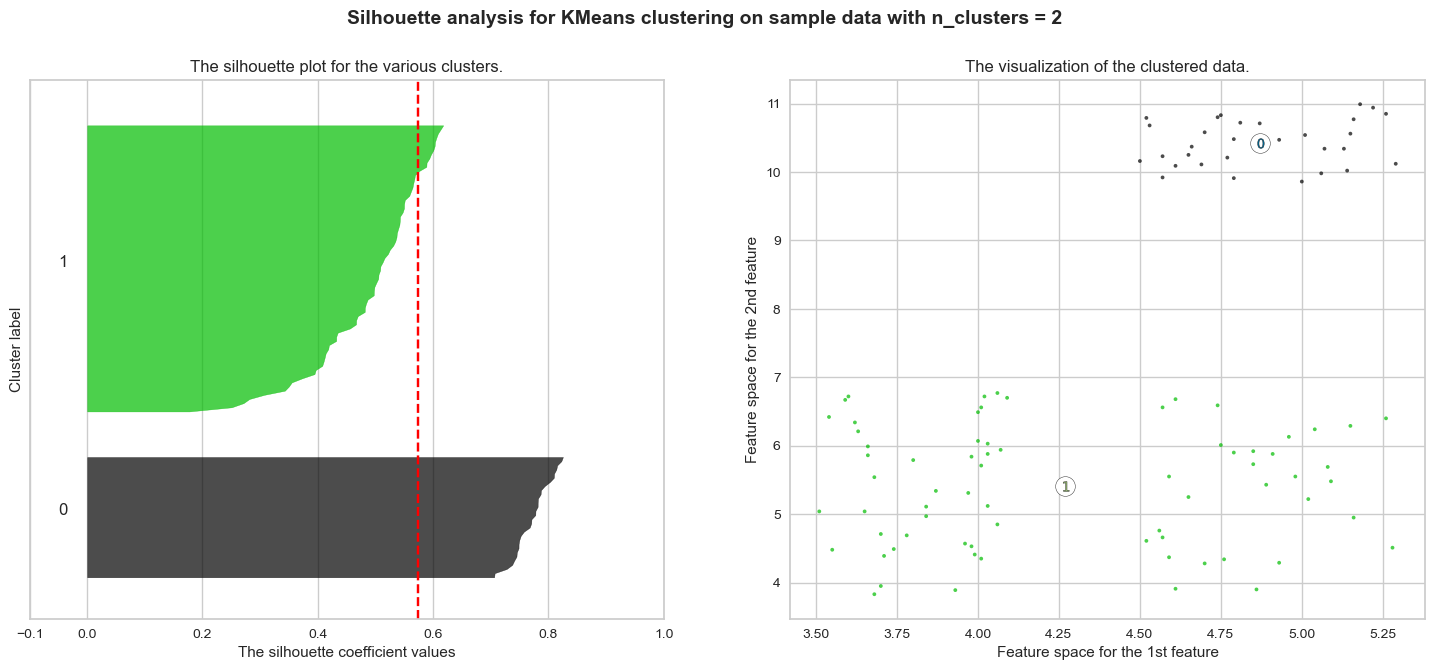

For n_clusters = 3 The average silhouette_score is : 0.644343998493909


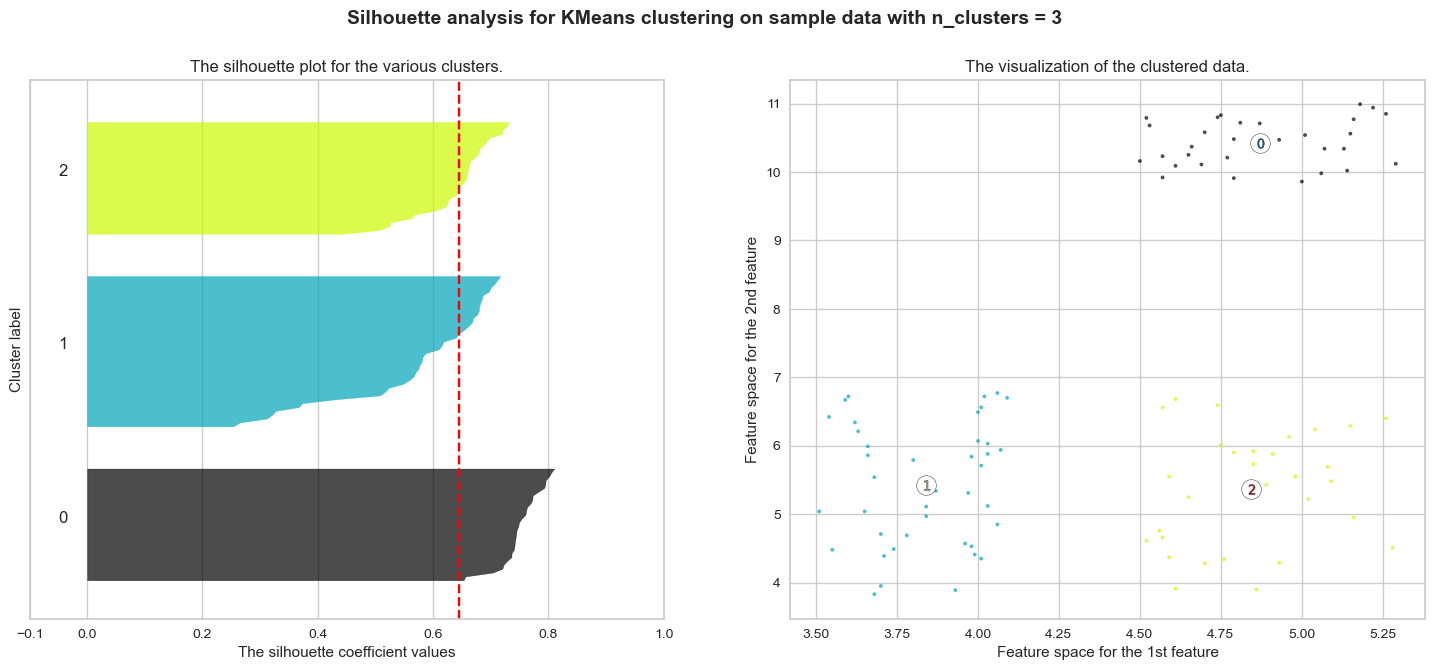

For n_clusters = 4 The average silhouette_score is : 0.5529979804479287


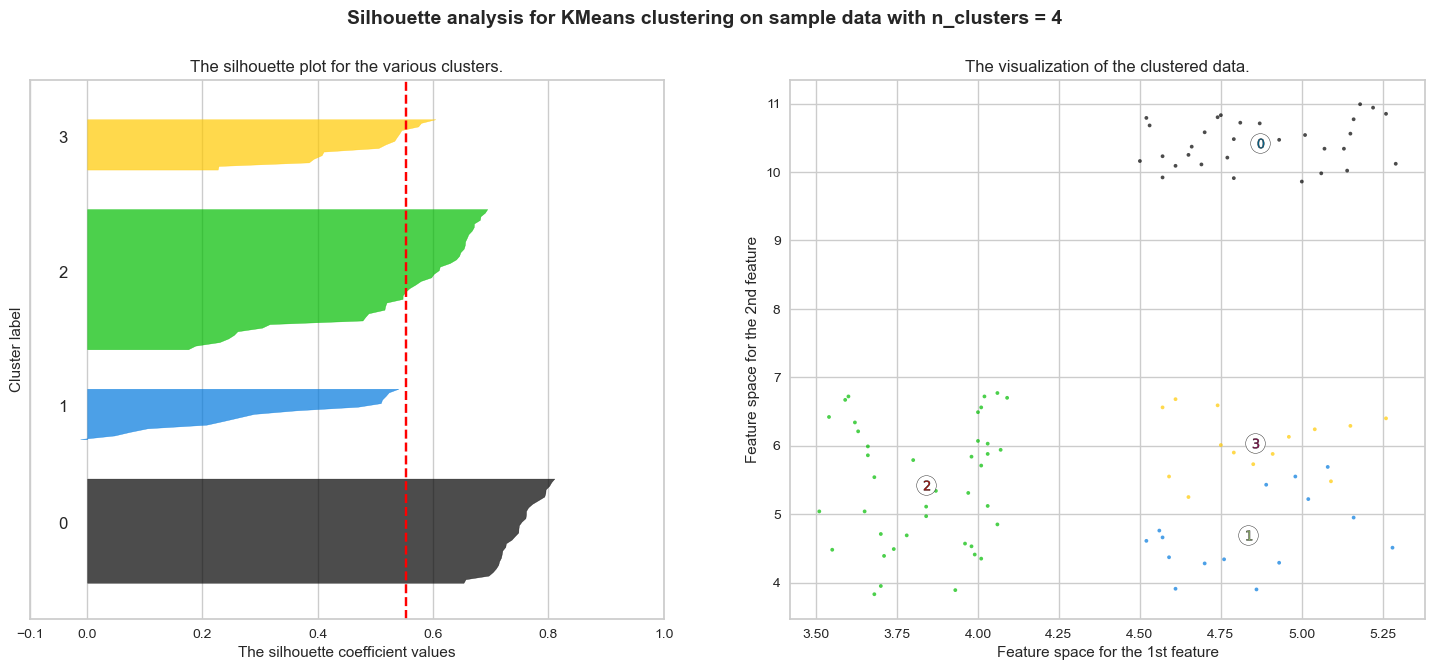

For n_clusters = 5 The average silhouette_score is : 0.48652625919544557


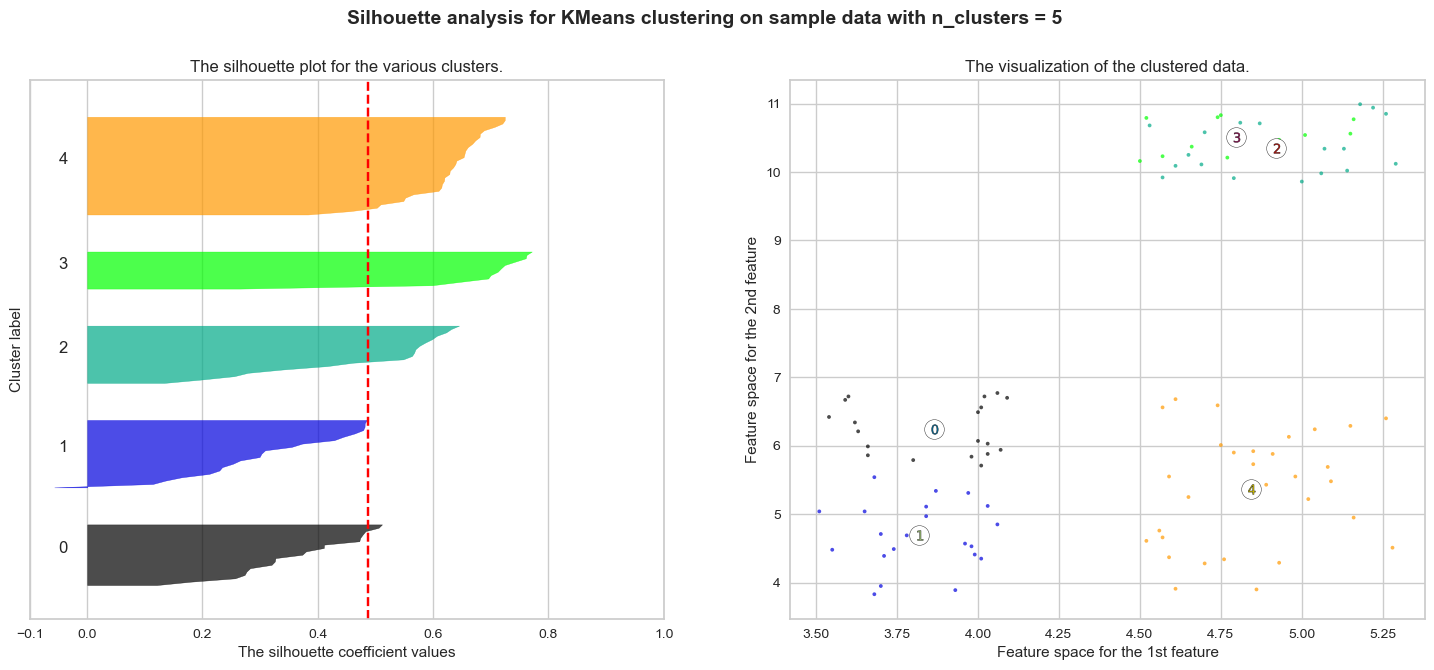

For n_clusters = 6 The average silhouette_score is : 0.4772597305186128


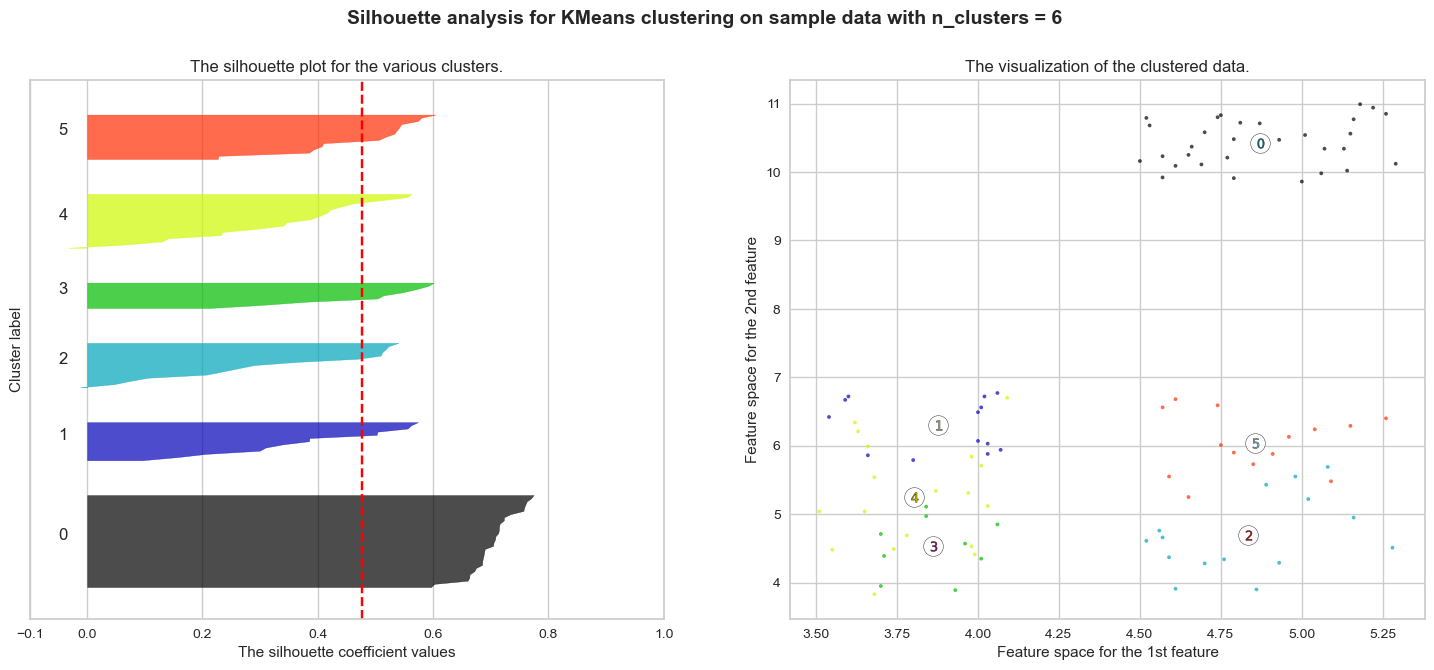

In [17]:
for k in range(2, 7):
    plot_Silhouette(EMR3d1, k)

##### Use graphic visualization of the Silhouette score to support your above answer:

- The highest average Silhouette score is found for k=3, which is what my analysis of the WCSS elbow showed.
- Additionally, the Silhouette scores for k=3 don't fluctuate too much.

#### From this section on - please use the sklearn's K-means

## Part 2: Mixture Models Clustering 

### Use K-Means to create clusters according to variables of both uniform and Gaussian distributions

c:\Users\kherz\anaconda3\envs\ydata\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\kherz\AppData\Local\Temp\ipykernel_28700\109056837.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


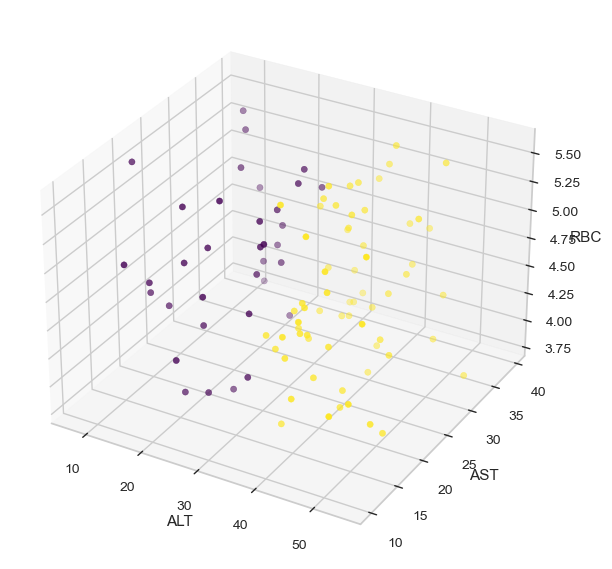

In [18]:
# Retrieve the ALT, AST and RBC column values from the dataset to cluster
variables2 = ["ALT","AST","RBC"]
EMR3d2 = sheet1.loc[:, variables2].values

# Run the K-Means algorithm
# NOTICE, this time, we know that the correct number of clusters is 2

# YOUR CODE HERE
y_pred_KMeans2 = KMeans(n_clusters=2).fit_predict(EMR3d2)

# Make a 3D chart
make_chart(EMR3d2, y_pred_KMeans2, variables2)

## Task 3 (_max score - 20 points_)
Scientists have found that in this population of patients, RBC distribution is uniform, ALT distribution is a Gaussian and AST distribution is a mixture of two Gaussians. Clearly, even by giving K-Means the correct K, the algorithm got to the wrong conclusion. This separation is "technically" correct, but lacks some underlying understanding of the natural phenomena.

What is the "problem" with this separation?

# Your answer here
The problem with the k-means separation is that it assumes spherical clusters. Since each feature/dimension has a different distribution (uniform, Gaussian, mixture of 2 Gaussians), the clusters are not expected to be spherical.

The downsides to k-means:
- lack of probabilistic cluster assignment
  - k-means model has no intrinsic measure of probability or uncertainty of cluster assignments
- lack of flexibility in cluster shape
  - k-means has no built-in way of accounting for oblong or elliptical clusters (instead it tried to force the data into spherical clusters)

The Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset

In order to exploit the Gaussian characteristic of the AST
1. Find the 2 componenets that comprise the AST feature by applying the GMM algorith with the proper number of components.
2. Assume that the clusters above are correct for the entire dataset (including the other features).
3. Show the final clusters (of EMR3d2) in a 3D chart

In [19]:
# Add your code for task3 after this line, and keep it in this cell.
from sklearn.mixture import GaussianMixture

# Get AST as column vector.
AST = np.expand_dims(sheet1.loc[:, "AST"].values, axis=1)

gmm = GaussianMixture(n_components=2)
gmm.fit(AST)

c:\Users\kherz\anaconda3\envs\ydata\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


GaussianMixture(n_components=2)

In [20]:
print("Means of Gaussian fit of AST:")
gmm.means_

Means of Gaussian fit of AST:


array([[31.76263257],
       [17.24934496]])

In [21]:
print("Covariances of Gaussian fit of AST:")
gmm.covariances_

Covariances of Gaussian fit of AST:


array([[[12.61002424]],

       [[ 7.98567696]]])

C:\Users\kherz\AppData\Local\Temp\ipykernel_28700\109056837.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


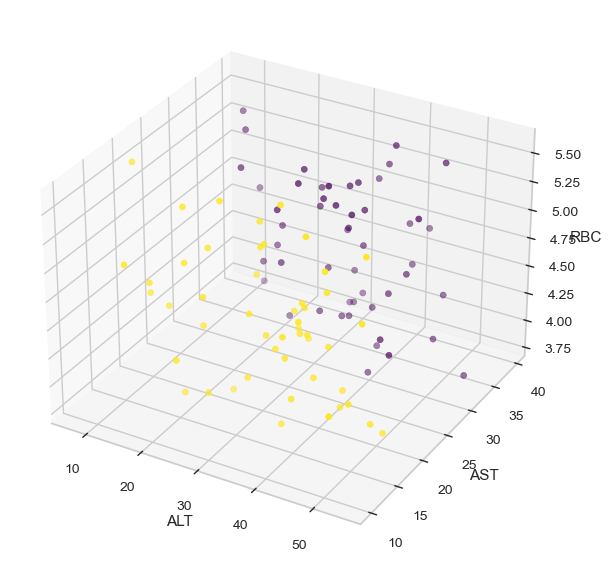

In [22]:
# Make a 3D chart
labels = gmm.predict(AST)
make_chart(EMR3d2, labels, variables2)

What is the difference between the two clustering results above?

 - Using k-means, clustering was performed primarily in the ALT dimension, without much/any splitting in the other dimensions.
 - Using a Gaussian mixture model trained along the AST dimension, we observe a clear split in the AST dimension, and no splitting in the other dimensions.

Which one, given the domain knowledge provided to you, makes more sense?

- Since we know that AST is comprised of a mixture of 2 Gaussians, while ALT is Gaussian distributed and RBC is uniformly distributed, it makes more sense to split into 2 clusters along the AST dimension than along the ALT dimension.




# Good Luck!

